In [1]:
import json

In [65]:


experiments_path = "../"

def fc_to_string(k,cfg):
    res = f"k_{k}bits_"
    for layer in cfg:
        res += str(layer["bits"]) + "."
    
    res +=  "logsize_"
    for layer in cfg:
        res = res + str(layer["logsize"]) + "."
    
    return res


def bits_str(cfg):
    res = "b."
    for layer in cfg:
        res += str(layer["bits"]) + "."
    
    return res

def logsize_str(cfg):
    res = "sz."
    for layer in cfg:
        res = res + str(layer["logsize"]) + "."
    
    return res
  
def load_configs(name):
    with open(f'{experiments_path}config_{name}', 'r') as myfile:
        data=myfile.read()
        obj = json.loads(data)
        return obj["config"]  

def load_exp(fn):
    try:
        with open(fn, 'r') as myfile:
            data=myfile.read()
            # print(data)
            obj = json.loads(data)
            return obj
    except Exception as err:
        print(err)
        return None

    
polygon_sets = ["tl_2017_us_zcta510", "Global_LSIB_Polygons_Detailed"]
datasets =["twitter_1mio_coords.h5", "twitter_10mio_coords.h5"]

In [15]:
k = 8;
x = 0;
width = 16 * 8192
height = 16 * 8192;
exp_name = "test_polygons";

cfgs = load_configs(exp_name)

9 16
{'b.1.': 0, 'b.1.8.': 1, 'b.1.16.': 2, 'b.1.32.': 3, 'b.1.64.': 4, 'b.8.': 5, 'b.8.16.': 6, 'b.8.32.': 7, 'b.8.64.': 8}
{'sz.16.': 0, 'sz.16.20.': 1, 'sz.16.24.': 2, 'sz.16.28.': 3, 'sz.20.': 4, 'sz.20.16.': 5, 'sz.20.24.': 6, 'sz.20.28.': 7, 'sz.24.': 8, 'sz.24.16.': 9, 'sz.24.20.': 10, 'sz.24.28.': 11, 'sz.28.': 12, 'sz.28.16.': 13, 'sz.28.20.': 14, 'sz.28.24.': 15}


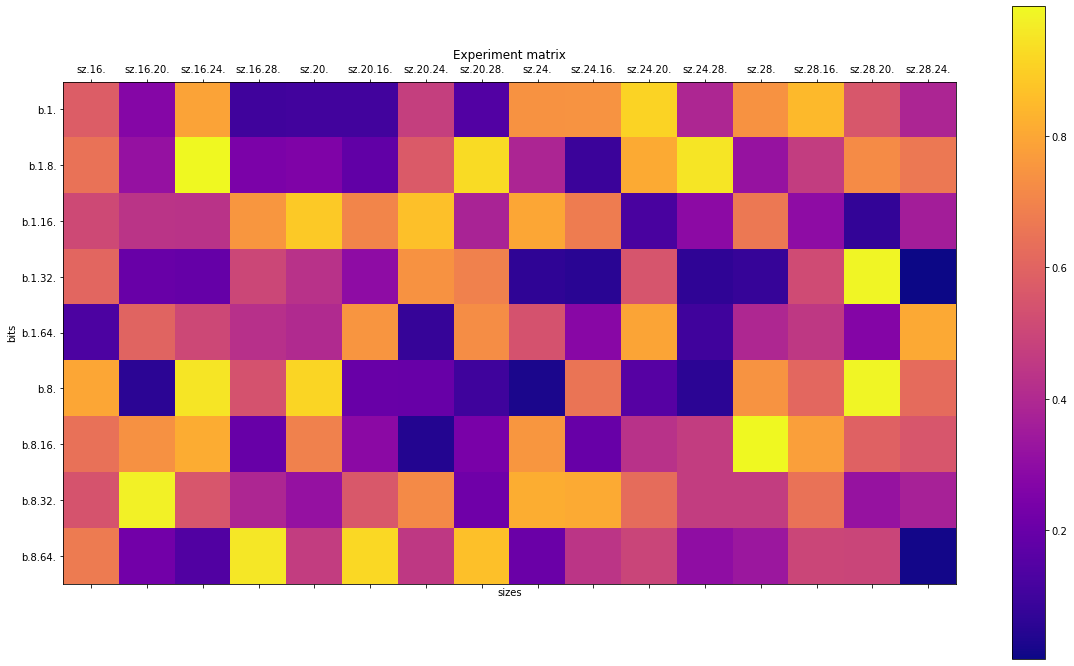

In [63]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np



def plot_matrix(cm, title='Experiment matrix', cmap='plasma', xlabels=None, ylabels=None):
    fig = plt.figure(figsize=(20, 12))
    ax = fig.add_subplot(111)
    # ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
    # ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    cax = ax.matshow(cm,cmap=cmap)
    plt.title(title)
    ax.set_xticks(range(len(xlabels)))
    ax.set_yticks(range(len(ylabels)))
    fig.colorbar(cax)
    if xlabels:
        ax.set_xticklabels(list(xlabels))
    if ylabels:
        ax.set_yticklabels(list(ylabels))
    plt.xlabel('sizes')
    plt.ylabel('bits')
    plt.show()


def make_maps(size, cfgs):
    bits_map = {}
    logsize_map = {}

    count_bits =0
    count_sizes = 0
    for c in cfgs :

        if len(c) <=2:
            if(not bits_str(c) in bits_map):
                bits_map[bits_str(c)] = count_bits
                count_bits+=1
            if(not logsize_str(c) in logsize_map):
                logsize_map[logsize_str(c)] = count_sizes
                count_sizes+=1
    return bits_map, logsize_map

bits_map, logsize_map = make_maps(2,cfgs)

print(len(bits_map), len(logsize_map))
print(bits_map)
print(logsize_map)
a = np.random.rand(len(bits_map), len(logsize_map))
plot_matrix(a, ylabels=bits_map.keys(), xlabels=logsize_map.keys())


Expecting value: line 1 column 1 (char 0)
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0399.1-k_8bits_1.8.32.logsize_28.24.16.twitter_10mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0400.0-k_8bits_1.8.64.logsize_28.24.16.twitter_1mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0400.0-k_8bits_1.8.64.logsize_28.24.16.twitter_10mio_coords.h5.tl_2017_us_zcta510.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0400.1-k_8bits_1.8.64.logsize_28.24.16.twitter_1mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygons.w131072h131072.0400.1-k_8bits_1.8.64.logsize_28.24.16.twitter_10mio_coords.h5.Global_LSIB_Polygons_Detailed.json'
[Errno 2] No such file or directory: '../test_polygons/test_polygon

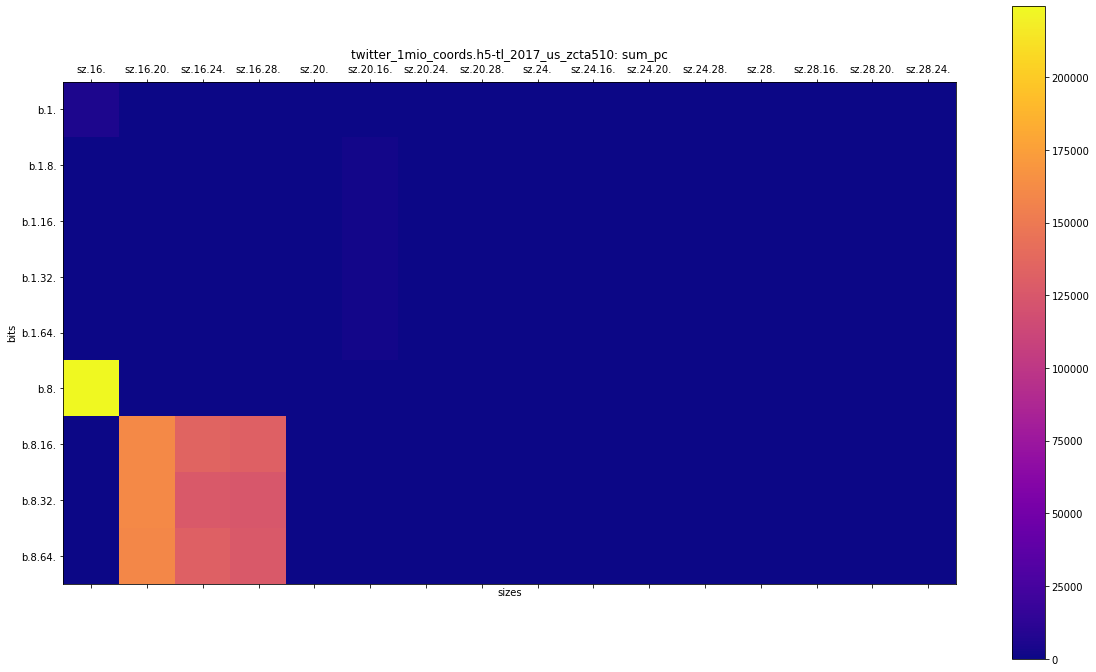

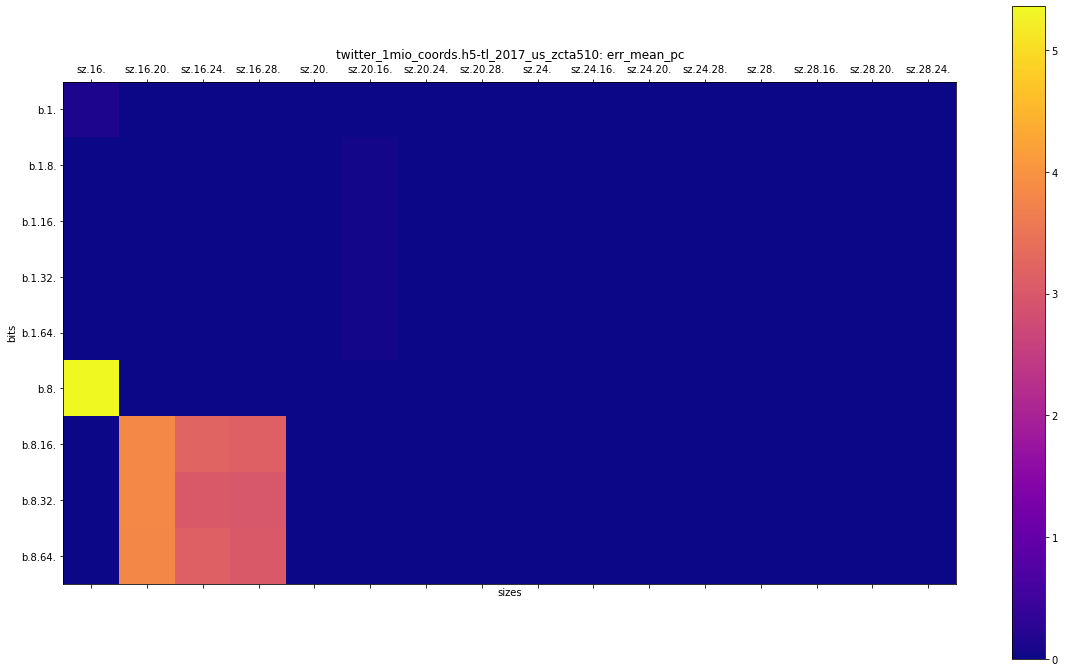

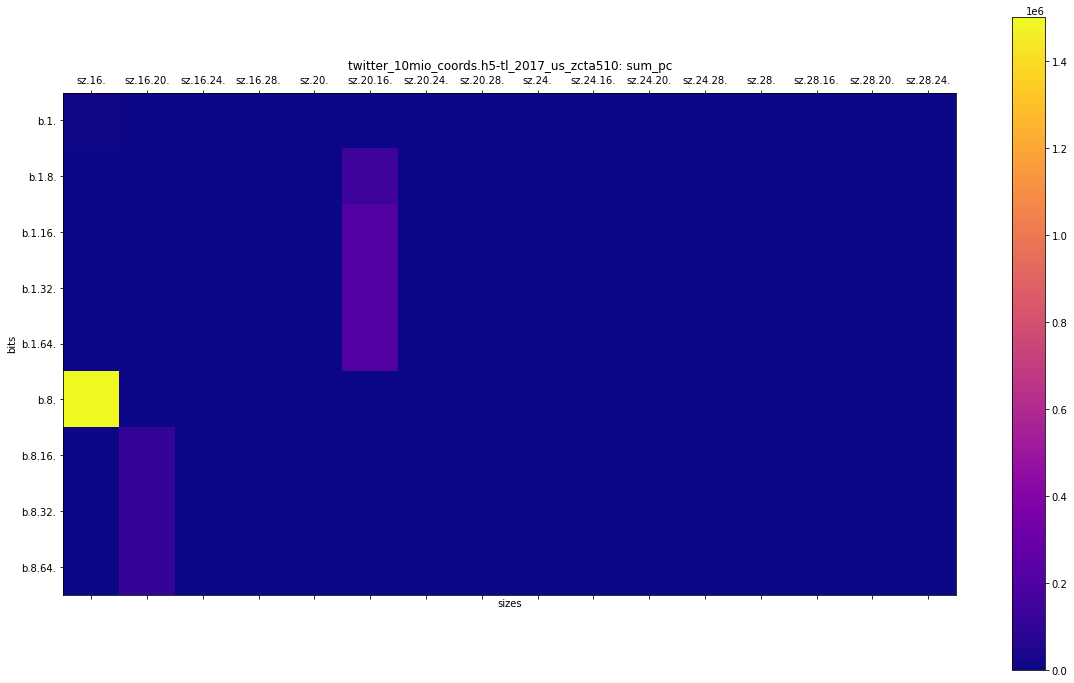

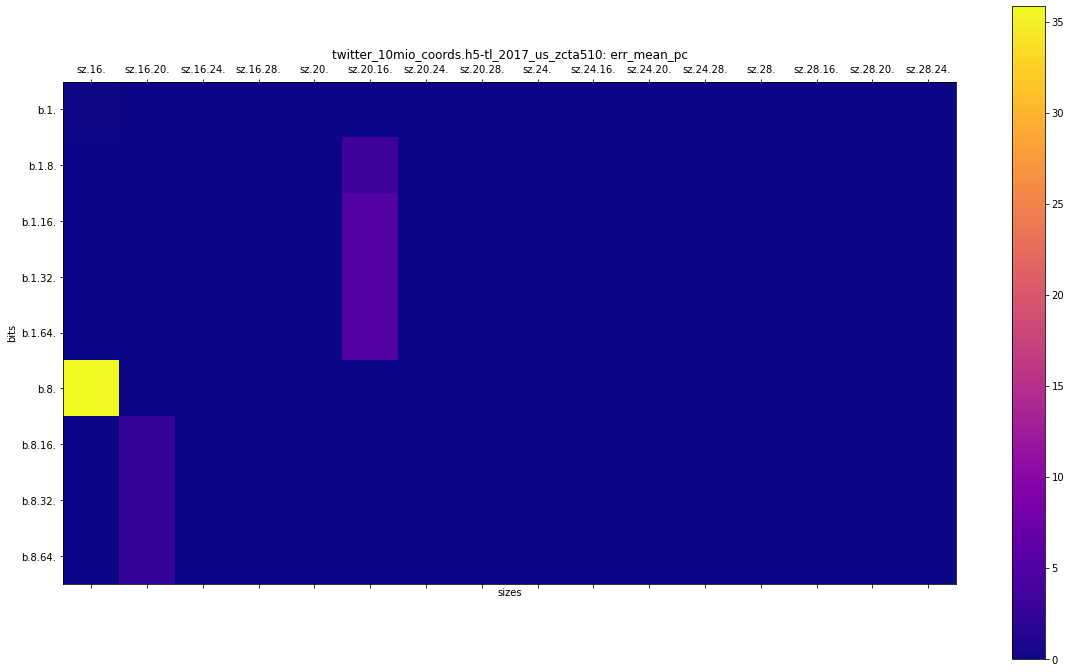

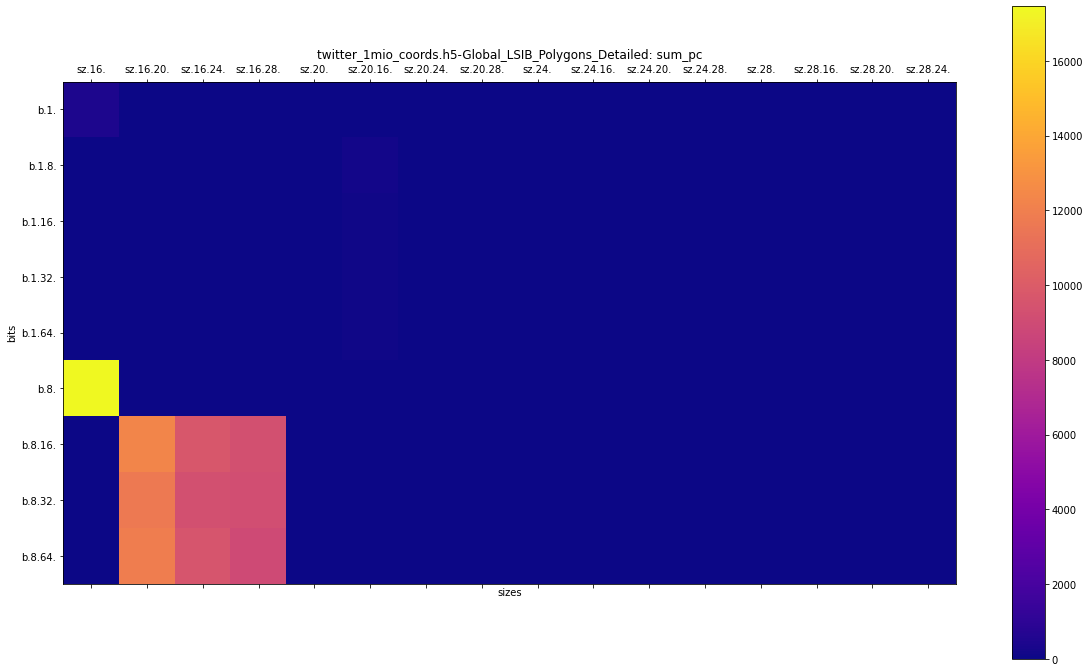

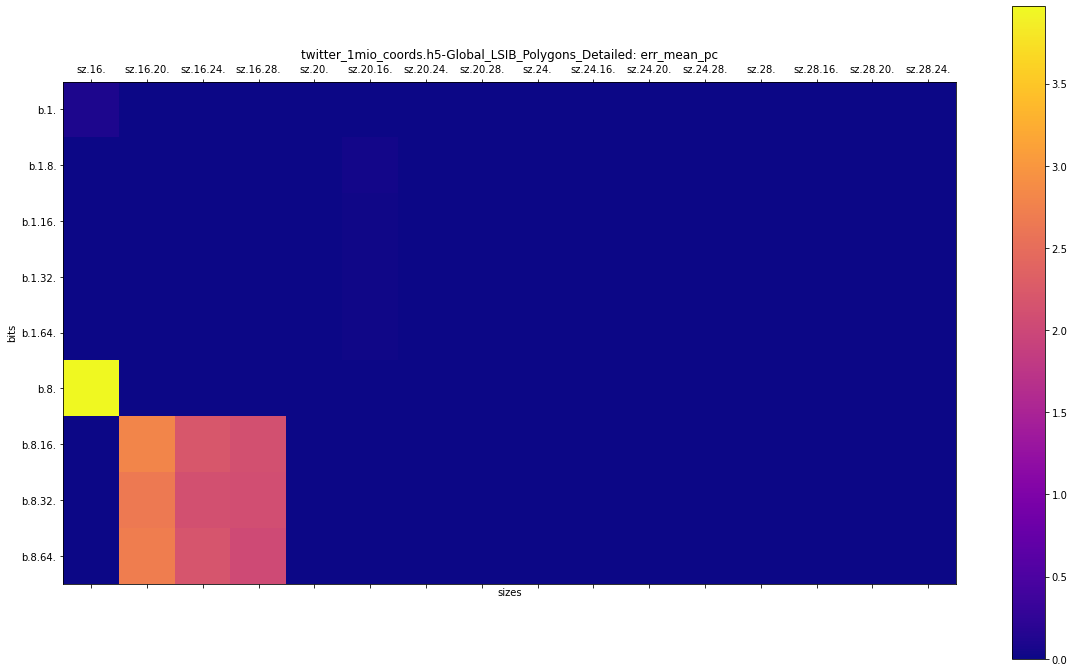

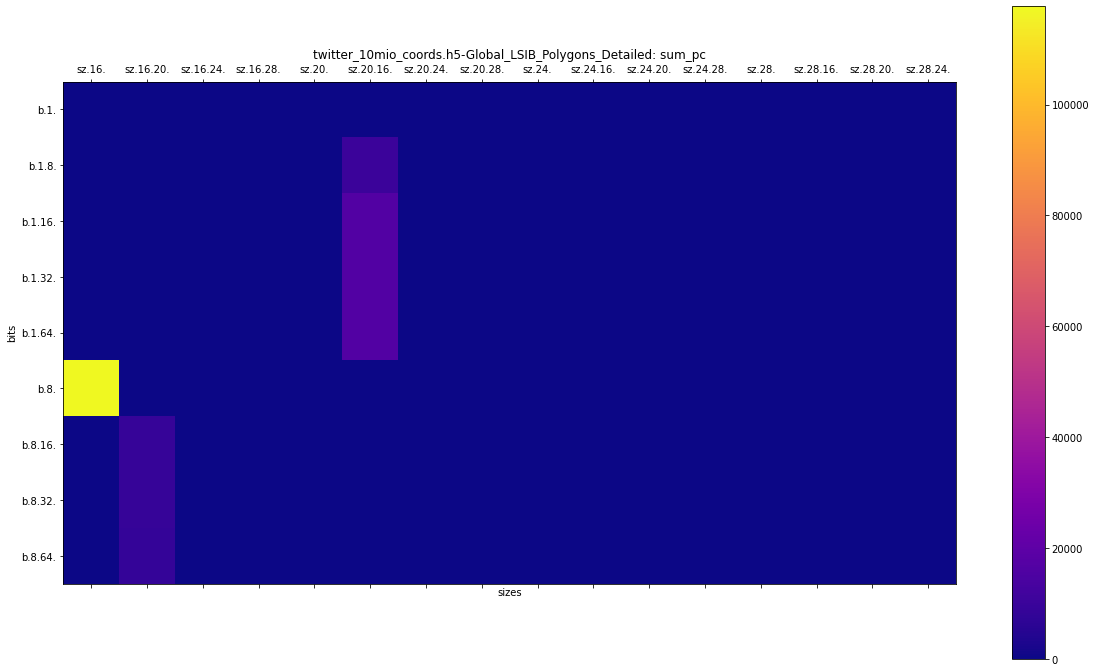

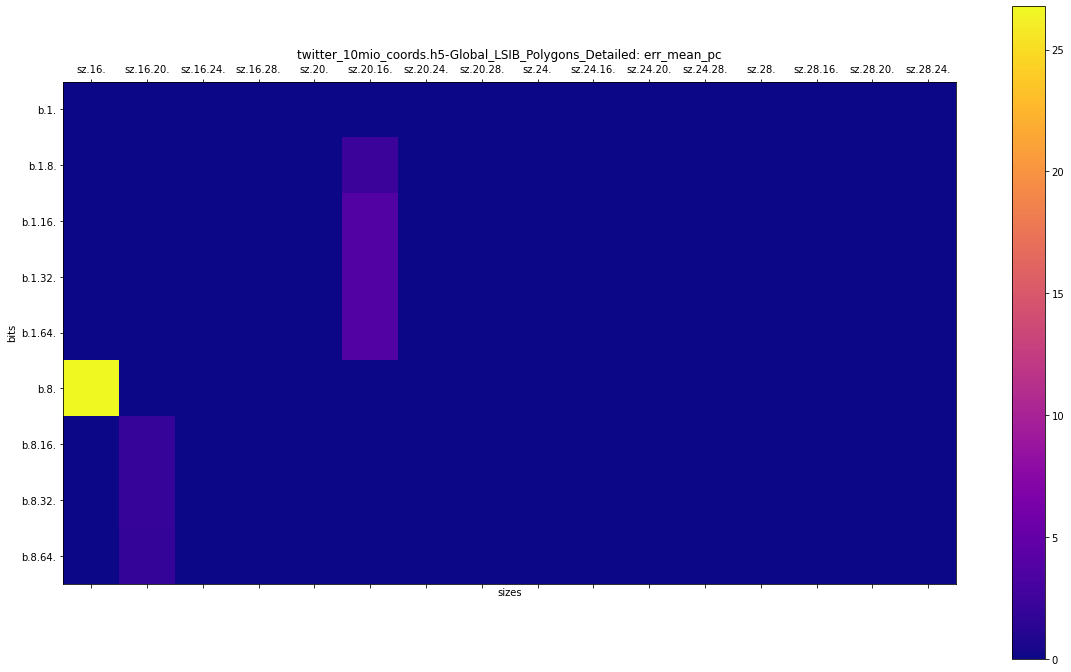

In [76]:
matrices= {}
matrix_indices = ["sum_pc", "err_mean_pc"]
for shapef in polygon_sets:
    matrices[shapef] = {}
    for  ds in datasets :
        matrices[shapef][ds] = {}
        for mi in matrix_indices:
            matrices[shapef][ds][mi] = np.zeros((len(bits_map),(len(logsize_map))))-1


x=0
for c in cfgs :
    # print(fc_to_string(k,c))
    y = 0;
    for shapef in polygon_sets:
        for  ds in datasets :
            fn = experiments_path + exp_name + "/" + exp_name + f'.w{width}h{height}.{x:04d}.{y}-' + fc_to_string(k,c) \
            + ds + "." + shapef + ".json"
            # print(fn)
            data = load_exp(fn)
            bits = bits_str(c)
            sz = logsize_str(c)
            if data and bits in bits_map and  sz in logsize_map:
                for mi in matrix_indices:
                    matrices[shapef][ds][mi][ bits_map[bits],logsize_map[sz]] = data[mi]
        y+=1
    x+=1
            
for shapef in polygon_sets:
    for  ds in datasets :
        for mi in matrix_indices:   
            plot_matrix( matrices[shapef][ds][mi] ,title=f'{ds}-{shapef}: {mi}',ylabels=bits_map.keys(), xlabels=logsize_map.keys())             